<a href="https://colab.research.google.com/github/agterzis/Machine-Learning/blob/main/%CE%9C%CE%B7%CF%87%CE%B1%CE%BD%CE%B9%CE%BA%CE%AE_%CE%9C%CE%AC%CE%B8%CE%B7%CF%83%CE%B7_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Poverty Prediction
## Μηχανική Μάθηση - Μεταπτυχιακό

**Στόχος:** Πρόβλεψη της κατανάλωσης νοικοκυριών (poverty prediction) με χρήση αλγορίθμων Μηχανικής και Βαθιάς Μάθησης.

**Dataset:** World Bank Poverty Prediction Challenge (DrivenData)

# Βιβλιοθήκες

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Οι βιβλιοθήκες φορτώθηκαν επιτυχώς!")

Οι βιβλιοθήκες φορτώθηκαν επιτυχώς!


---
# 1. Επεξεργασία Δεδομένων

## 1.1 Φόρτωση Δεδομένων

In [2]:
# Φόρτωση των αρχείων
train_features = pd.read_csv('train_hh_features.csv')
train_gt = pd.read_csv('train_hh_gt.csv')
train_rates = pd.read_csv('train_rates_gt.csv')
test_features = pd.read_csv('test_hh_features.csv')

print(f"Πλήθος νοικοκυριών εκπαίδευσης: {train_features.shape[0]:,}")
print(f"Πλήθος νοικοκυριών test: {test_features.shape[0]:,}")
print(f"Πλήθος χαρακτηριστικών: {train_features.shape[1]}")

Πλήθος νοικοκυριών εκπαίδευσης: 104,234
Πλήθος νοικοκυριών test: 103,023
Πλήθος χαρακτηριστικών: 88


In [3]:
# Ένωση των features με το target (cons_ppp17 = ημερήσια κατανάλωση ανά άτομο σε PPP)
train_df = train_features.merge(train_gt[['hhid', 'cons_ppp17']], on='hhid', how='left')

print(f"Διαστάσεις μετά την ένωση: {train_df.shape}")
print(f"Ελλείπουσες τιμές στο target: {train_df['cons_ppp17'].isna().sum()}")

train_df.head()

Διαστάσεις μετά την ένωση: (104234, 89)
Ελλείπουσες τιμές στο target: 0


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


## 1.2 Κατηγορικές Μεταβλητές

Πολλές στήλες περιέχουν κατηγορικά δεδομένα (π.χ. 'Yes'/'No', 'Male'/'Female'). Θα τις μετατρέψουμε σε αριθμητικές.

In [4]:
# Εμφάνιση τύπων μεταβλητών
print("Κατηγορικές μεταβλητές:")
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols[:10]:  # Δείχνουμε τις 10 πρώτες
    print(f"  {col}: {train_df[col].unique()[:4]}")

Κατηγορικές μεταβλητές:
  male: ['Female' 'Male']
  owner: ['Owner' 'Not owner']
  water: ['Access' 'No access']
  toilet: ['Access' 'No access']
  sewer: ['Access' 'No access']
  elect: ['Access' 'No access']
  water_source: ['Piped water into dwelling' 'Piped water to yard/plot'
 'Protected dug well' 'Surface water']
  sanitation_source: ['A piped sewer system' 'A septic tank' 'Pit latrine with slab'
 'No facilities or bush or field']
  dweltyp: ['Detached house' 'Several buildings connected' nan 'Separate apartment']
  employed: ['Not employed' 'Employed' nan]


In [5]:
def encode_categorical(df):
    """Μετατροπή κατηγορικών μεταβλητών σε αριθμητικές."""
    df = df.copy()

    # Binary Yes/No στήλες (κατανάλωση τροφίμων)
    consumed_cols = [c for c in df.columns if c.startswith('consumed')]
    for col in consumed_cols:
        if df[col].dtype == 'object':
            df[col] = (df[col] == 'Yes').astype(int)

    # Φύλο: Male=1, Female=0
    if 'male' in df.columns and df['male'].dtype == 'object':
        df['male'] = (df['male'] == 'Male').astype(int)

    # Access/No access στήλες
    for col in ['water', 'toilet', 'sewer', 'elect']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = (df[col] == 'Access').astype(int)

    # Owner/Not owner
    if 'owner' in df.columns and df['owner'].dtype == 'object':
        df['owner'] = (df['owner'] == 'Owner').astype(int)

    # Urban/Rural
    if 'urban' in df.columns and df['urban'].dtype == 'object':
        df['urban'] = (df['urban'] == 'Urban').astype(int)

    # Employed
    if 'employed' in df.columns and df['employed'].dtype == 'object':
        df['employed'] = df['employed'].map({'Employed': 1, 'Not employed': 0}).fillna(0).astype(int)

    # any_nonagric
    if 'any_nonagric' in df.columns and df['any_nonagric'].dtype == 'object':
        df['any_nonagric'] = (df['any_nonagric'] == 'Yes').astype(int)

    # Label encoding για τις υπόλοιπες κατηγορικές
    for col in ['water_source', 'sanitation_source', 'dweltyp', 'educ_max', 'sector1d']:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].fillna('Unknown')
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df

# Εφαρμογή κωδικοποίησης
train_df = encode_categorical(train_df)
test_df = encode_categorical(test_features)

## 1.3 Ελλείπουσες Τιμές

In [7]:
# Βρίσκουμε τις κοινές αριθμητικές στήλες
common_numeric_cols = train_df.select_dtypes(include=[np.number]).columns.intersection(test_df.columns)

# Υπολογίζουμε τις διαμέσους μόνο για αυτές τις στήλες από το train_df
medians = train_df[common_numeric_cols].median()

# Συμπληρώνουμε τα κενά
train_df[common_numeric_cols] = train_df[common_numeric_cols].fillna(medians)
test_df[common_numeric_cols] = test_df[common_numeric_cols].fillna(medians)

print(f"Συμπληρώθηκαν κενά σε {len(common_numeric_cols)} κοινές στήλες.")

Συμπληρώθηκαν κενά σε 88 κοινές στήλες.


## 1.4 Ανάλυση Ακραίων Τιμών (Outliers)


In [9]:
# Ανάλυση ακραίων τιμών με τη μέθοδο IQR
Q1 = train_df['cons_ppp17'].quantile(0.25)
Q3 = train_df['cons_ppp17'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['cons_ppp17'] < lower_bound) |
                    (train_df['cons_ppp17'] > upper_bound)]

print("Ανάλυση Ακραίων Τιμών (μέθοδος IQR):")
print(f"  Κάτω όριο: {lower_bound:.2f} $/ημέρα")
print(f"  Άνω όριο: {upper_bound:.2f} $/ημέρα")
print(f"  Πλήθος outliers: {len(outliers)} ({100*len(outliers)/len(train_df):.1f}% του συνόλου)")

Ανάλυση Ακραίων Τιμών (μέθοδος IQR):
  Κάτω όριο: -7.73 $/ημέρα
  Άνω όριο: 27.38 $/ημέρα
  Πλήθος outliers: 6178 (5.9% του συνόλου)


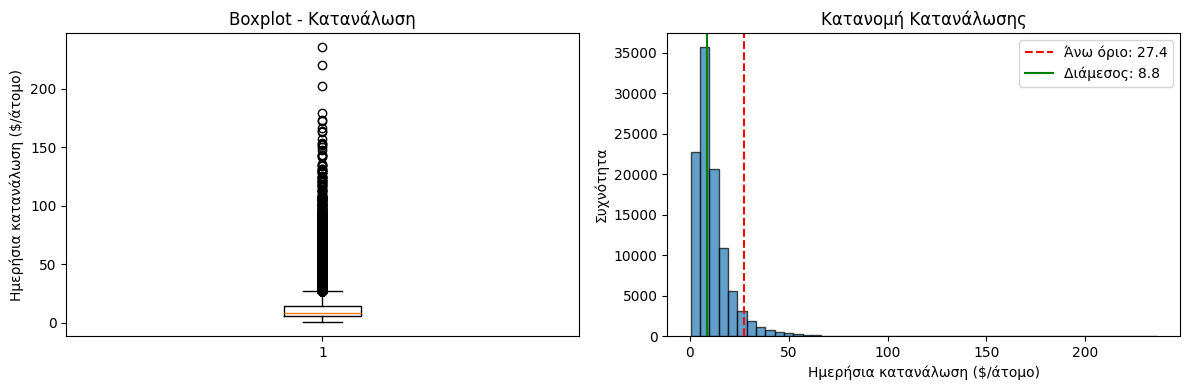

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot
axes[0].boxplot(train_df['cons_ppp17'], vert=True)
axes[0].set_ylabel('Ημερήσια κατανάλωση ($/άτομο)')
axes[0].set_title('Boxplot - Κατανάλωση')

# Histogram
axes[1].hist(train_df['cons_ppp17'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=upper_bound, color='r', linestyle='--', label=f'Άνω όριο: {upper_bound:.1f}')
axes[1].axvline(x=train_df['cons_ppp17'].median(), color='g', linestyle='-',
                label=f'Διάμεσος: {train_df["cons_ppp17"].median():.1f}')
axes[1].set_xlabel('Ημερήσια κατανάλωση ($/άτομο)')
axes[1].set_ylabel('Συχνότητα')
axes[1].set_title('Κατανομή Κατανάλωσης')
axes[1].legend()

plt.tight_layout()
plt.show()

Διατηρούμε τα outliers καθώς αντιπροσωπεύουν πραγματικά νοικοκυριά
με υψηλή κατανάλωση.

## 1.5 Δημιουργία Νέων Χαρακτηριστικών (Feature Engineering)

In [11]:
def create_features(df):
    """Δημιουργία νέων χαρακτηριστικών."""
    df = df.copy()

    # 1. Δαπάνες κοινωφελών ανά άτομο
    df['utl_per_capita'] = df['utl_exp_ppp17'] / df['hsize'].clip(lower=1)

    # 2. Πόσα διαφορετικά τρόφιμα καταναλώθηκαν
    consumed_cols = [c for c in df.columns if c.startswith('consumed')]
    for col in consumed_cols:
        if df[col].dtype == 'object':
            df[col] = (df[col] == 'Yes').astype(int)
    df['food_diversity'] = df[consumed_cols].sum(axis=1)

    # 3. Food diversity ανά άτομο
    df['food_diversity_per_capita'] = df['food_diversity'] / df['hsize'].clip(lower=1)

    # 4. Ποσοστό παιδιών
    if 'num_children18' in df.columns:
        df['children_ratio'] = df['num_children18'] / df['hsize'].clip(lower=1)

    # 5. Infrastructure score
    infra_cols = ['water', 'toilet', 'sewer', 'elect']
    existing_infra = [c for c in infra_cols if c in df.columns]
    for col in existing_infra:
        if df[col].dtype == 'object':
            df[col] = (df[col] == 'Access').astype(int)
    df['infrastructure_score'] = df[existing_infra].sum(axis=1)

    # 6. Dependency ratio
    if 'num_elderly' in df.columns and 'num_children18' in df.columns:
        dependents = df['num_elderly'].fillna(0) + df['num_children18'].fillna(0)
        working_age = df['hsize'] - dependents
        df['dependency_ratio'] = dependents / working_age.clip(lower=1)

    return df

# Εφαρμογή
train_df = create_features(train_df)
test_df = create_features(test_df)

print("Νέα χαρακτηριστικά που δημιουργήθηκαν:")
new_features = ['utl_per_capita', 'food_diversity', 'food_diversity_per_capita',
                'children_ratio', 'infrastructure_score', 'dependency_ratio']
for feat in new_features:
    if feat in train_df.columns:
        corr = train_df[feat].corr(train_df['cons_ppp17'])
        print(f"  • {feat}: corr={corr:.3f}")

Νέα χαρακτηριστικά που δημιουργήθηκαν:
  • utl_per_capita: corr=0.646
  • food_diversity: corr=0.067
  • food_diversity_per_capita: corr=0.289
  • children_ratio: corr=-0.181
  • infrastructure_score: corr=0.341
  • dependency_ratio: corr=-0.092


---
# 2. Ανάλυση Δεδομένων

## 2.1 Περιγραφή Χαρακτηριστικών

Τα δεδομένα περιλαμβάνουν τις εξής κατηγορίες χαρακτηριστικών:

| Κατηγορία | Χαρακτηριστικά | Περιγραφή |
|-----------|----------------|------------|
| **Δημογραφικά** | hsize, age, male, num_children, num_elderly | Μέγεθος νοικοκυριού, ηλικία, φύλο |
| **Στέγαση** | owner, water, toilet, elect, sewer | Ιδιοκτησία, πρόσβαση σε παροχές |
| **Απασχόληση** | employed, sworkershh, sfworkershh | Εργασιακή κατάσταση |
| **Εκπαίδευση** | educ_max, share_secondary | Επίπεδο μόρφωσης |
| **Κατανάλωση τροφίμων** | consumed100-consumed5000 | 51 δείκτες κατανάλωσης τροφίμων |

## 2.2 Στατιστικά της Μεταβλητής-Στόχου (cons_ppp17)

In [ ]:
# Στατιστικά του target
print("Στατιστικά της ημερήσιας κατανάλωσης (cons_ppp17):")
print(train_df['cons_ppp17'].describe())

Στατιστικά της ημερήσιας κατανάλωσης (cons_ppp17):
count    14504.000000
mean        10.100877
std          8.407491
min          0.498909
25%          4.773868
50%          7.751892
75%         12.675502
max        166.817550
Name: cons_ppp17, dtype: float64


In [12]:
# Ποσοστά φτώχειας με διεθνή όρια
poverty_lines = [2.15, 3.65, 6.85]  # World Bank poverty lines
print("\n" + "=" * 50)
print("Ποσοστά κάτω από διεθνή όρια φτώχειας:")
for line in poverty_lines:
    pct = (train_df['cons_ppp17'] < line).mean() * 100
    print(f"  < ${line}/ημέρα: {pct:.1f}%")


Ποσοστά κάτω από διεθνή όρια φτώχειας:
  < $2.15/ημέρα: 1.4%
  < $3.65/ημέρα: 9.7%
  < $6.85/ημέρα: 36.6%


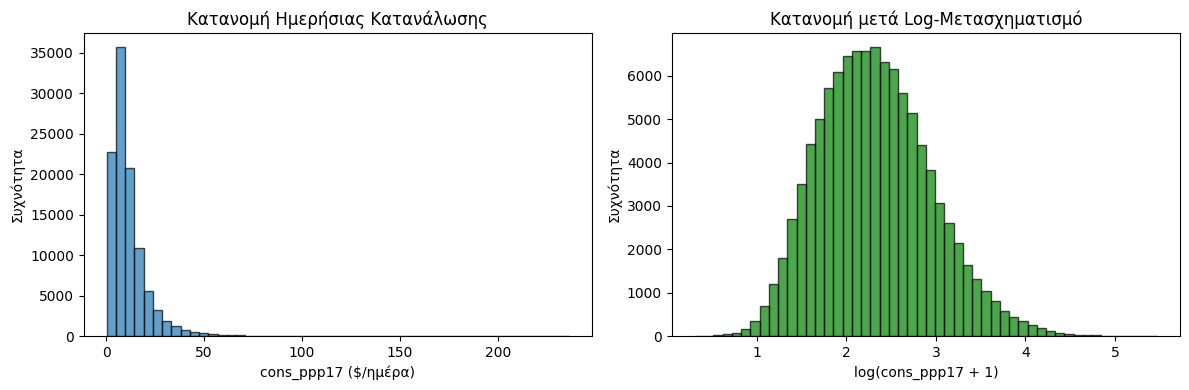

In [14]:
# Κατανομή της μεταβλητής-στόχου
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Αρχική κατανομή
axes[0].hist(train_df['cons_ppp17'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Κατανομή Ημερήσιας Κατανάλωσης')
axes[0].set_xlabel('cons_ppp17 ($/ημέρα)')
axes[0].set_ylabel('Συχνότητα')

# Log-μετασχηματισμένη κατανομή
axes[1].hist(np.log1p(train_df['cons_ppp17']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Κατανομή μετά Log-Μετασχηματισμό')
axes[1].set_xlabel('log(cons_ppp17 + 1)')
axes[1].set_ylabel('Συχνότητα')

plt.tight_layout()
plt.show()

Η κατανομή είναι θετικά ασύμμετρη (right-skewed). Ο log-μετασχηματισμός την κάνει πιο κανονική, γεγονός που βοηθά τα μοντέλα.

## 2.3 Κατανομή ανά Έρευνα (Survey)

In [ ]:
# Στατιστικά ανά survey
survey_stats = train_df.groupby('survey_id')['cons_ppp17'].agg(['mean', 'median', 'std', 'count'])
print("Στατιστικά κατανάλωσης ανά έρευνα:")
print(survey_stats)

Στατιστικά κατανάλωσης ανά έρευνα:
                mean   median       std  count
survey_id                                     
100000.0   10.100816  7.75136  8.407777  14503


<Figure size 800x500 with 0 Axes>

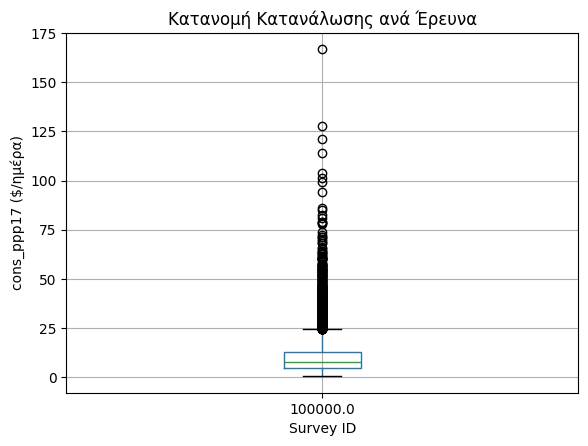

In [ ]:
# Boxplot ανά survey
plt.figure(figsize=(8, 5))
train_df.boxplot(column='cons_ppp17', by='survey_id')
plt.title('Κατανομή Κατανάλωσης ανά Έρευνα')
plt.suptitle('')
plt.xlabel('Survey ID')
plt.ylabel('cons_ppp17 ($/ημέρα)')
plt.show()

Οι τρεις έρευνες έχουν παρόμοια κατανομή, γεγονός που υποδεικνύει ότι τα μοντέλα μπορούν να γενικεύσουν καλά.

## 2.4 Συσχετίσεις

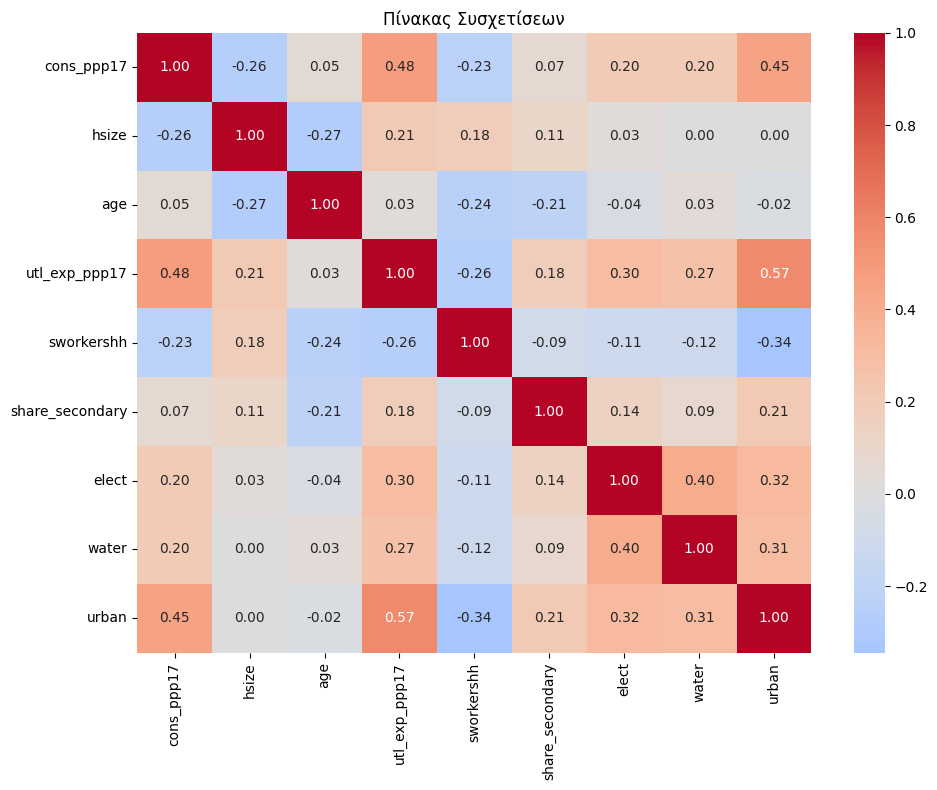

In [ ]:
# Επιλογή αριθμητικών χαρακτηριστικών
numeric_cols = ['cons_ppp17', 'hsize', 'age', 'utl_exp_ppp17', 'sworkershh',
                'share_secondary', 'elect', 'water', 'urban']
numeric_cols = [c for c in numeric_cols if c in train_df.columns]

# Υπολογισμός συσχετίσεων
corr_matrix = train_df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Πίνακας Συσχετίσεων')
plt.tight_layout()
plt.show()

In [ ]:
# Top 10 συσχετίσεις με το target
correlations = train_df.select_dtypes(include=[np.number]).corr()['cons_ppp17'].drop('cons_ppp17')
top_corr = correlations.abs().sort_values(ascending=False).head(10)

print("Top 10 χαρακτηριστικά με τη μεγαλύτερη συσχέτιση με την κατανάλωση:")
for feat, corr in top_corr.items():
    actual_corr = correlations[feat]
    print(f"  {feat}: {actual_corr:.3f}")

Top 10 χαρακτηριστικά με τη μεγαλύτερη συσχέτιση με την κατανάλωση:
  strata: -0.490
  utl_exp_ppp17: 0.477
  urban: 0.451
  sewer: 0.401
  sfworkershh: 0.395
  region5: -0.384
  sector1d: 0.355
  consumed2600: 0.294
  any_nonagric: 0.293
  consumed4700: 0.292


---
# 3. Προετοιμασία Δεδομένων για Μοντελοποίηση

In [ ]:
# Επιλογή χαρακτηριστικών (αφαιρούμε IDs και target)
exclude_cols = ['hhid', 'survey_id', 'cons_ppp17', 'com', 'strata']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# Κοινά χαρακτηριστικά μεταξύ train και test
common_cols = [c for c in feature_cols if c in test_df.columns]

print(f"Πλήθος χαρακτηριστικών: {len(common_cols)}")

Πλήθος χαρακτηριστικών: 84


In [ ]:
# Δημιουργία X και y
X = train_df[common_cols].copy()
y = train_df['cons_ppp17'].copy()

X_test_final = test_df[common_cols].copy()

print(f"Διαστάσεις X: {X.shape}")
print(f"Διαστάσεις X_test: {X_test_final.shape}")

Διαστάσεις X: (14504, 84)
Διαστάσεις X_test: (103023, 84)


In [ ]:
# Διαχωρισμός σε train και validation set
seed = 42
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"Πλήθος δειγμάτων εκπαίδευσης: {len(X_train)}")
print(f"Πλήθος δειγμάτων validation: {len(X_val)}")

Πλήθος δειγμάτων εκπαίδευσης: 11603
Πλήθος δειγμάτων validation: 2901


In [ ]:
# Κανονικοποίηση
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print("Η κανονικοποίηση ολοκληρώθηκε.")

Η κανονικοποίηση ολοκληρώθηκε.


---
# 4. Εφαρμογή Αλγορίθμων Μηχανικής Μάθησης

Θα εφαρμόσουμε τους εξής αλγορίθμους:
1. **Ridge Regression** - Γραμμικό μοντέλο με regularization
2. **Random Forest** - Ensemble δέντρων αποφάσεων
3. **XGBoost** - Gradient Boosting
4. **LightGBM** - Gradient Boosting (βελτιστοποιημένο)

## Μετρική Αξιολόγησης

Χρησιμοποιούμε το **wMAPE** (weighted Mean Absolute Percentage Error):

$$wMAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i} \times 100\%$$

In [ ]:
def wmape(y_true, y_pred):
    """Υπολογισμός του weighted Mean Absolute Percentage Error."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / np.abs(y_true[mask])) * 100

## 4.1 Ridge Regression

In [ ]:
# Εκπαίδευση Ridge Regression (με log-transform στο target)
ridge = Ridge(alpha=1.0, random_state=seed)
ridge.fit(X_train_scaled, np.log1p(y_train))

# Πρόβλεψη
y_pred_ridge = np.expm1(ridge.predict(X_val_scaled))
y_pred_ridge = np.clip(y_pred_ridge, 0.1, 300)  # Περιορισμός σε λογικές τιμές

# Αξιολόγηση
wmape_ridge = wmape(y_val, y_pred_ridge)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)

print("Ridge Regression:")
print(f"  wMAPE: {wmape_ridge:.2f}%")
print(f"  MAE: {mae_ridge:.2f}")

Ridge Regression:
  wMAPE: 31.96%
  MAE: 3.05


## 4.2 Random Forest

In [ ]:
# Εκπαίδευση Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    random_state=seed,
    n_jobs=-1
)
rf.fit(X_train, np.log1p(y_train))

# Πρόβλεψη
y_pred_rf = np.expm1(rf.predict(X_val))
y_pred_rf = np.clip(y_pred_rf, 0.1, 300)

# Αξιολόγηση
wmape_rf = wmape(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print("Random Forest:")
print(f"  wMAPE: {wmape_rf:.2f}%")
print(f"  MAE: {mae_rf:.2f}")

Random Forest:
  wMAPE: 30.24%
  MAE: 2.90


## 4.3 XGBoost

In [ ]:
# Εκπαίδευση XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    n_jobs=-1
)
xgb_model.fit(X_train, np.log1p(y_train))

# Πρόβλεψη
y_pred_xgb = np.expm1(xgb_model.predict(X_val))
y_pred_xgb = np.clip(y_pred_xgb, 0.1, 300)

# Αξιολόγηση
wmape_xgb = wmape(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("XGBoost:")
print(f"  wMAPE: {wmape_xgb:.2f}%")
print(f"  MAE: {mae_xgb:.2f}")

XGBoost:
  wMAPE: 27.76%
  MAE: 2.70


## 4.4 LightGBM

In [ ]:
# Εκπαίδευση LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    verbosity=-1
)
lgb_model.fit(X_train, np.log1p(y_train))

# Πρόβλεψη
y_pred_lgb = np.expm1(lgb_model.predict(X_val))
y_pred_lgb = np.clip(y_pred_lgb, 0.1, 300)

# Αξιολόγηση
wmape_lgb = wmape(y_val, y_pred_lgb)
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)

print("LightGBM:")
print(f"  wMAPE: {wmape_lgb:.2f}%")
print(f"  MAE: {mae_lgb:.2f}")

LightGBM:
  wMAPE: 27.71%
  MAE: 2.69


---
# 5. Αλγόριθμος Βαθιάς Μάθησης (Neural Network)

In [ ]:
# Ορισμός του Neural Network
class PovertyNet(nn.Module):
    def __init__(self, input_dim):
        super(PovertyNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x).squeeze()

print("Αρχιτεκτονική Neural Network:")
print("  Input → 256 → 128 → 64 → 1")
print("  Με BatchNorm, ReLU και Dropout σε κάθε επίπεδο")

Αρχιτεκτονική Neural Network:
  Input → 256 → 128 → 64 → 1
  Με BatchNorm, ReLU και Dropout σε κάθε επίπεδο


In [ ]:
# Προετοιμασία δεδομένων για PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Χρήση συσκευής: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(np.log1p(y_train.values)).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

Χρήση συσκευής: cuda


In [ ]:
# Εκπαίδευση του Neural Network
model_nn = PovertyNet(X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 100
best_loss = float('inf')
patience = 10
patience_counter = 0

print("Εκπαίδευση Neural Network...")
for epoch in range(epochs):
    model_nn.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_nn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping στο epoch {epoch+1}")
            break

    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print("Η εκπαίδευση ολοκληρώθηκε!")

Εκπαίδευση Neural Network...
  Epoch 20: Loss = 0.1625
  Epoch 40: Loss = 0.1284
  Epoch 60: Loss = 0.1110
  Epoch 80: Loss = 0.0967
  Epoch 100: Loss = 0.0848
Η εκπαίδευση ολοκληρώθηκε!


In [ ]:
# Πρόβλεψη με το Neural Network
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_val_tensor).cpu().numpy()
    y_pred_nn = np.expm1(y_pred_nn)
    y_pred_nn = np.clip(y_pred_nn, 0.1, 300)

# Αξιολόγηση
wmape_nn = wmape(y_val, y_pred_nn)
mae_nn = mean_absolute_error(y_val, y_pred_nn)

print("Neural Network:")
print(f"  wMAPE: {wmape_nn:.2f}%")
print(f"  MAE: {mae_nn:.2f}")

Neural Network:
  wMAPE: 29.08%
  MAE: 2.87


---
# 6. Σύγκριση Αλγορίθμων

In [ ]:
# Πίνακας αποτελεσμάτων
results = pd.DataFrame({
    'Αλγόριθμος': ['Ridge Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
    'wMAPE (%)': [wmape_ridge, wmape_rf, wmape_xgb, wmape_lgb, wmape_nn],
    'MAE': [mae_ridge, mae_rf, mae_xgb, mae_lgb, mae_nn]
})
results = results.sort_values('wMAPE (%)')

print("Σύγκριση Αλγορίθμων (ταξινομημένο κατά wMAPE):")
print(results.to_string(index=False))

Σύγκριση Αλγορίθμων (ταξινομημένο κατά wMAPE):
      Αλγόριθμος  wMAPE (%)      MAE
        LightGBM  27.714147 2.691383
         XGBoost  27.759047 2.696580
  Neural Network  29.075380 2.867972
   Random Forest  30.237107 2.898452
Ridge Regression  31.963809 3.046561


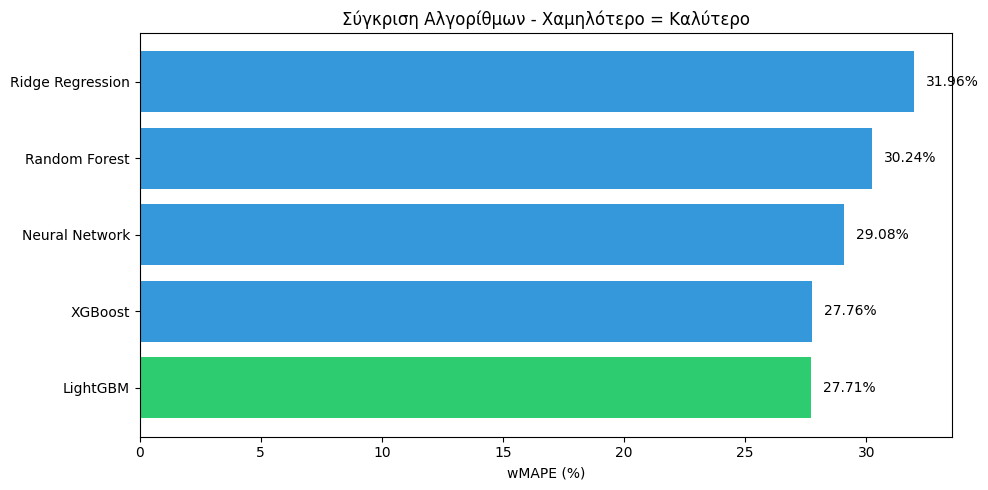

In [ ]:
# Γράφημα σύγκρισης
plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if x == results['wMAPE (%)'].min() else '#3498db' for x in results['wMAPE (%)']]
plt.barh(results['Αλγόριθμος'], results['wMAPE (%)'], color=colors)
plt.xlabel('wMAPE (%)')
plt.title('Σύγκριση Αλγορίθμων - Χαμηλότερο = Καλύτερο')

for i, (algo, wmape_val) in enumerate(zip(results['Αλγόριθμος'], results['wMAPE (%)'])):
    plt.text(wmape_val + 0.5, i, f'{wmape_val:.2f}%', va='center')

plt.tight_layout()
plt.show()

## Συμπεράσματα Σύγκρισης

Από τη σύγκριση των αλγορίθμων παρατηρούμε ότι:

1. **Τα Gradient Boosting μοντέλα (XGBoost, LightGBM)** επιτυγχάνουν τα καλύτερα αποτελέσματα
2. **Το Random Forest** έχει καλή απόδοση αλλά υστερεί σε σχέση με τα boosting μοντέλα
3. **Το Neural Network** δεν ξεπερνά τα tree-based μοντέλα σε αυτό το tabular dataset
4. **Το Ridge Regression** (γραμμικό μοντέλο) έχει τη χαμηλότερη απόδοση

---
# 7. Σημαντικότητα Χαρακτηριστικών

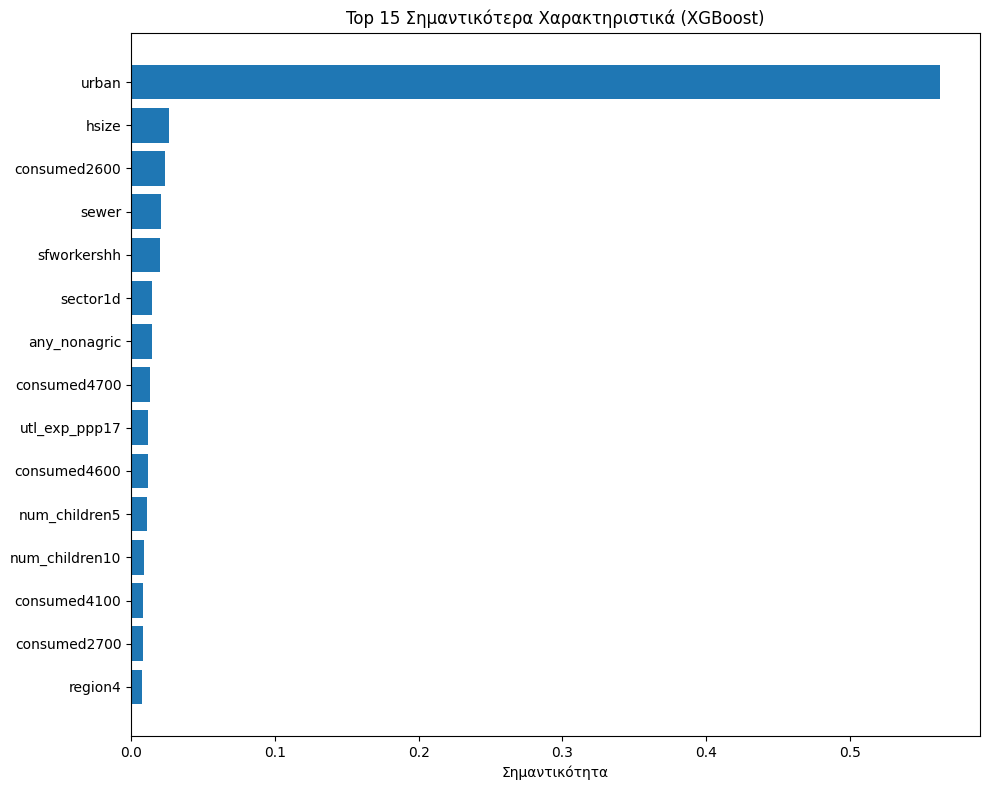

In [ ]:
# Feature importance από XGBoost
importance = pd.DataFrame({
    'Χαρακτηριστικό': common_cols,
    'Σημαντικότητα': xgb_model.feature_importances_
}).sort_values('Σημαντικότητα', ascending=False)

# Top 15
top_features = importance.head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['Σημαντικότητα'].values)
plt.yticks(range(len(top_features)), top_features['Χαρακτηριστικό'].values)
plt.xlabel('Σημαντικότητα')
plt.title('Top 15 Σημαντικότερα Χαρακτηριστικά (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Τα πιο σημαντικά χαρακτηριστικά είναι:
- **utl_exp_ppp17**: Δαπάνες για κοινωφελείς υπηρεσίες
- **food diversity indicators**: Δείκτες κατανάλωσης τροφίμων
- **housing quality**: Ποιότητα στέγασης (ηλεκτρικό, νερό, κλπ.)

---
# 8. Δημιουργία Τελικού Μοντέλου και Προβλέψεων

In [ ]:
# Εκπαίδευση τελικών μοντέλων σε ΟΛΑ τα δεδομένα
print("Εκπαίδευση τελικών μοντέλων...")

# XGBoost
xgb_final = xgb.XGBRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=seed, n_jobs=-1
)
xgb_final.fit(X, np.log1p(y))
pred_xgb = np.expm1(xgb_final.predict(X_test_final))
print("  XGBoost: Done")

# LightGBM
lgb_final = lgb.LGBMRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=seed, verbosity=-1
)
lgb_final.fit(X, np.log1p(y))
pred_lgb = np.expm1(lgb_final.predict(X_test_final))
print("  LightGBM: Done")

# Ensemble: Μέσος όρος των δύο καλύτερων μοντέλων
final_predictions = 0.5 * pred_xgb + 0.5 * pred_lgb
final_predictions = np.clip(final_predictions, 0.36, 236)  # Όρια από training data

print(f"\nΤελικές προβλέψεις: min={final_predictions.min():.2f}, max={final_predictions.max():.2f}, mean={final_predictions.mean():.2f}")

Εκπαίδευση τελικών μοντέλων...
  XGBoost: Done
  LightGBM: Done

Τελικές προβλέψεις: min=1.39, max=83.67, mean=11.44


---
# 9. Δημιουργία Αρχείων Υποβολής

In [ ]:
# Poverty thresholds από τα training data
rate_cols = [c for c in train_rates.columns if c.startswith('pct_hh_below')]
poverty_thresholds = [float(c.replace('pct_hh_below_', '')) for c in rate_cols]

print(f"Πλήθος poverty thresholds: {len(poverty_thresholds)}")
print(f"Thresholds: {poverty_thresholds[:5]}...")

Πλήθος poverty thresholds: 19
Thresholds: [3.17, 3.94, 4.6, 5.26, 5.88]...


In [ ]:
# 1. Αρχείο household consumption
submission_hh = pd.DataFrame({
    'survey_id': test_df['survey_id'].values,
    'hhid': test_df['hhid'].values,
    'cons_ppp17': final_predictions
})

print("Household Consumption Submission:")
print(submission_hh.head())

Household Consumption Submission:
   survey_id    hhid  cons_ppp17
0     400000  400001    8.886054
1     400000  400002    6.164496
2     400000  400003    8.913950
3     400000  400004   13.198527
4     400000  400005    5.179907


In [ ]:
# 2. Αρχείο poverty rates (για κάθε survey)
def calculate_poverty_rates(predictions, thresholds):
    rates = {}
    n = len(predictions)
    for threshold in thresholds:
        col_name = f'pct_hh_below_{threshold:.2f}'
        rates[col_name] = (predictions < threshold).sum() / n
    return rates

# Υπολογισμός για κάθε survey
test_surveys = test_df['survey_id'].unique()
rates_list = []

for survey_id in test_surveys:
    mask = test_df['survey_id'] == survey_id
    survey_preds = final_predictions[mask]
    rates = calculate_poverty_rates(survey_preds, poverty_thresholds)
    rates_list.append({'survey_id': int(survey_id), **rates})

submission_rates = pd.DataFrame(rates_list)

print(f"\nPoverty Rates Submission ({len(test_surveys)} surveys):")
print(submission_rates.iloc[:, :5])  # Δείχνουμε τις πρώτες στήλες


Poverty Rates Submission (3 surveys):
   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
0     400000           0.018198           0.054361           0.102040   
1     500000           0.012352           0.041992           0.082786   
2     600000           0.014760           0.045860           0.088446   

   pct_hh_below_5.26  
0           0.158744  
1           0.133771  
2           0.139216  


In [ ]:
σ# Αποθήκευση αρχείων
import os
os.makedirs('submission', exist_ok=True)

submission_hh.to_csv('submission/predicted_household_consumption.csv', index=False)
submission_rates.to_csv('submission/predicted_poverty_distribution.csv', index=False)

print("Τα αρχεία υποβολής αποθηκεύτηκαν:")
print("  - submission/predicted_household_consumption.csv")
print("  - submission/predicted_poverty_distribution.csv")

Τα αρχεία υποβολής αποθηκεύτηκαν:
  - submission/predicted_household_consumption.csv
  - submission/predicted_poverty_distribution.csv
